# Masked Style Transfer

The purpose of this notebook is to prepare a utility function that allows semantic style transfer. It would take in a dictionary of segment labels and styles before performing individual style transfer and subsequent combination. 

Pretrained model used here is Magenta for fast style transfer.

In [1]:
# import functools
import os

# from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.7.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  []


2021-11-19 11:05:19.031263: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
##### Utility functions related to showing and saving images

def show_img(images, titles=('',), figsize=(20, 8)):
  plt.figure(figsize=figsize)
  imgs = len(images)
  for i, img in enumerate(images):
    plt.subplot(1, imgs, i + 1)
    if tf.is_tensor(img):
    # if type(img) == tf.python.framework.ops.EagerTensor:
      # The output image is by default an EagerTensor instance, hence we will need to squeeze the image dimensions for display
      images[i] = np.squeeze(images[i])
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
  plt.show()

def save_image(img, filename, savedir):
    plt.imsave(os.path.join(savedir, filename), img)

In [13]:
##### Utility functions related to loading the magenta model and stylizing image using magenta model

def load_magenta_model():
    cwd = os.getcwd()

    # Load image stylization module.
    hub_handle = os.path.join(cwd, 'models', 'magenta')
    hub_module = hub.load(hub_handle)
    return hub_module

def style_img_magenta(content_image, style_image, hub_module):
    # Convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]. Example using numpy:
    ctm = content_image.copy()
    stm = style_image.copy()
    ctm = ctm.astype(np.float32)[np.newaxis, ...] / 255.
    stm = stm.astype(np.float32)[np.newaxis, ...] / 255.

    # Optionally resize the images. It is recommended that the style image is about
    # 256 pixels (this size was used when training the style transfer network).
    # The content image can be any size.
    stm = tf.image.resize(stm, (256, 256))

    # Stylize image
    outputs = hub_module(tf.constant(ctm), tf.constant(stm))
    stylized_image = outputs[0]
    return stylized_image
hub_module = load_magenta_model()

The content images available by default are: ['klcc.jpg', 'msia1.jpg', 'msia2.jpg', 'sanfran1.jpg', 'sanfran2.jpg', 'sanfran3.jpg']

The style images available by default are: ['kandinsky.jpg', 'seated-nude.jpg', 'shipwreck.jpg', 'starry-night.jpg', 'the-scream.jpg', 'woman-with-hat-matisse.jpg']



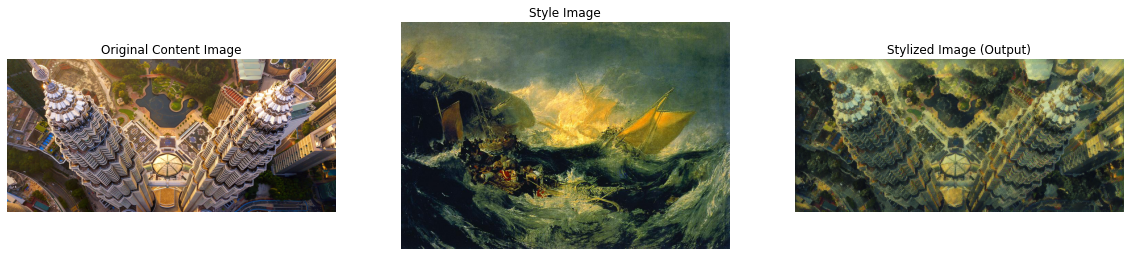

In [14]:
# Main program here
cwd = os.getcwd()
img_dir = os.path.join(cwd, 'images')
output_dir = os.path.join(cwd, 'output')

if not os.path.isdir(output_dir):
    os.mkdir(os.path.join(cwd, output_dir))

# Content image to be chosen
content_image_path = './klcc.jpg'
content_images = os.listdir(os.path.join(img_dir, 'content'))
content_images = sorted(content_images)
print(f'The content images available by default are: {content_images}\n')
content_img = content_images[0]
content_image_path = os.path.join(img_dir, 'content', content_img)
content_image = plt.imread(content_image_path)

# Choosing style image
style_images = os.listdir(os.path.join(img_dir, 'styles'))
style_images = sorted(style_images)
print(f'The style images available by default are: {style_images}\n')
style_img = style_images[2]

style_image_path = os.path.join(img_dir, 'styles', style_img)
style_image = plt.imread(style_image_path)


stylized_image = style_img_magenta(content_image=content_image, style_image=style_image, hub_module=hub_module)
stylized_image = np.squeeze(stylized_image)  # Prepare EagerTensor image for display

save_image(stylized_image, 'styled_output.jpg', output_dir)  # Save stylized image
show_img([content_image, style_image, stylized_image], titles=['Original Content Image', 'Style Image', 'Stylized Image (Output)'])

# Masked Style Transfer

In [15]:
# def get_style_path(style_img):
#     return os.path.join(img_dir, 'styles', style_img)

def masked_stylize(content_image, mask, segment_styles):
    # `styles` parameter MUST BE a list of styles, if no style for the current class index, specify as `None`
    styles_to_segment = set(segment_styles.keys())
    n_sty = len(styles_to_segment)
    
    mask_classes = list(np.unique(mask))
    n_classes = len(mask_classes)

    if ((n_sty > n_classes) or n_sty == 0):
        raise Exception('Error: number of styles does not match the number of segmented regions in the mask or no style is passed in')

    norm_ctm = content_image.copy().astype(np.float32) / 255.
    stylized_image = norm_ctm.copy()
    cur_mask = 0  # Temporary variable that stores the mask for the current class involved
    cur_layer = 0  # Temporary variable that stores the processed layer for the current class involved

    for i, val in enumerate(mask_classes):
        # `val` indicates the value of the current class within the image mask
        if i not in styles_to_segment:
            continue

        cur_layer = norm_ctm.copy()
        cur_mask = mask.copy()
        cur_mask = (cur_mask == val).astype(np.uint8)  # Getting only the current class as the active mask
        cur_layer = style_img_magenta(cur_layer, segment_styles.get(i), hub_module)  # Get style of current layer
        cur_layer = np.squeeze(cur_layer)  # Convert EagerTensor instance to a typical image dimension

        for j in range(stylized_image.shape[0]):
            for k in range(stylized_image.shape[1]):
                if cur_mask[j][k] == 1:
                    stylized_image[j][k] = cur_layer[j][k].copy()

    return stylized_image

In [16]:
print(f'The content images available by default are: {content_images}\n')
print(f'The style images available by default are: {style_images}\n')

The content images available by default are: ['klcc.jpg', 'msia1.jpg', 'msia2.jpg', 'sanfran1.jpg', 'sanfran2.jpg', 'sanfran3.jpg']

The style images available by default are: ['kandinsky.jpg', 'seated-nude.jpg', 'shipwreck.jpg', 'starry-night.jpg', 'the-scream.jpg', 'woman-with-hat-matisse.jpg']



In [17]:
cwd = os.getcwd()

# Configure file names and paths
segment_images_dir = os.path.join(cwd, 'segmentation_test_img')
base = 'guy1'
img_path = os.path.join(segment_images_dir, f'{base}.jpg')
mask_path = os.path.join(segment_images_dir, f'{base}_mask.png')

# Read in the input image and mask
img = plt.imread(img_path)
img = img.astype(int)
mask = plt.imread(mask_path)
mask = mask.astype(int)

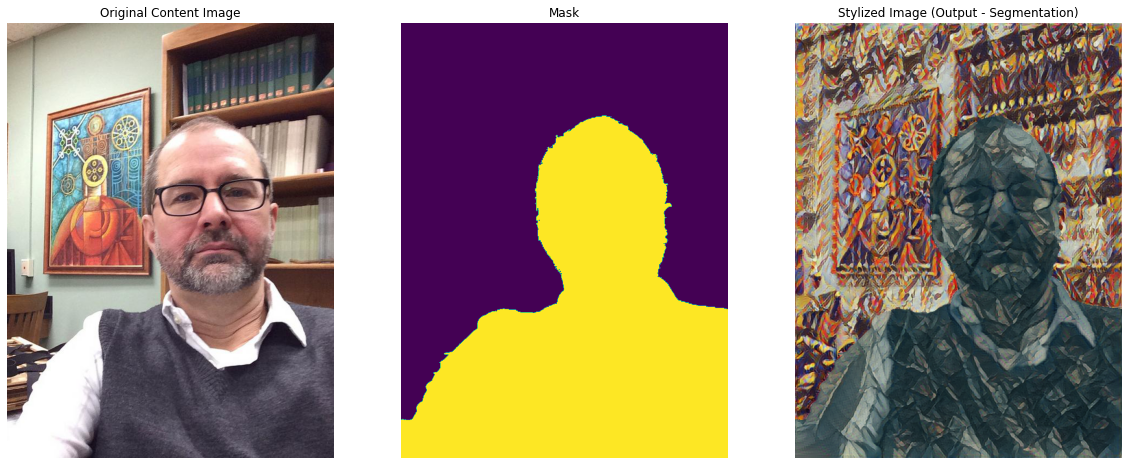

In [18]:
segment_styles = {0: style_images[0], 1: style_images[1]}  # Style both foreground and background
# segment_styles = {0: style_images[1]}  # Only style foreground
# segment_styles = {1: style_images[1]}  # Only style background

for region, style_img in segment_styles.items():
    segment_styles[region] = plt.imread(os.path.join(img_dir, 'styles', style_img))

masked_stylized = masked_stylize(img, mask, segment_styles)
show_img([img, mask, masked_stylized], titles=['Original Content Image', 'Mask', 'Stylized Image (Output - Segmentation)'])

This shows that masked style transfer is in fact viable. The next step is generating this mask automatically through a segmentation model and modularising this function for consumption by the app.